<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: Mariya Mansurova, Analyst & developer in Yandex.Metrics team. Translated by Ivan Zakharov, ML enthusiast. <br>This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis) + [solution](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis-solution).**

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

warnings.filterwarnings("ignore")
import pandas as pd
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

## Data preparation

In [2]:
df = pd.read_csv("../../data/wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index("date")[["count"]])

In [6]:
from prophet import Prophet

In [7]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


Create train_df and leave space for N predictions.

In [8]:
train_df = df[:-predictions].copy()
train_df.index = train_df['ds']

Train the Prophet on this training dataset

In [9]:
p = Prophet()
p.fit(train_df)

10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing


Form dataframe with future dates that we want to predict

In [10]:
future_df = p.make_future_dataframe(periods=predictions, include_history=False)
future_df.tail(5)

,ds
25,2016-01-16
26,2016-01-17
27,2016-01-18
28,2016-01-19
29,2016-01-20


Predict the selected dates

In [11]:
pred = p.predict(future_df)
pred.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
25,2016-01-16,2975.100998,1673.193706,2490.194116,2956.249210,2998.486346,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,0.0,0.0,0.0,2112.555034
26,2016-01-17,2980.432400,1842.575332,2688.739222,2960.426020,3005.045993,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,0.0,0.0,0.0,2258.906661
27,2016-01-18,2985.763803,2858.817550,3650.279985,2964.919852,3011.807086,281.375854,281.375854,281.375854,281.375854,281.375854,281.375854,0.0,0.0,0.0,3267.139657
28,2016-01-19,2991.095205,3123.895951,3978.793109,2969.236149,3018.756772,542.213022,542.213022,542.213022,542.213022,542.213022,542.213022,0.0,0.0,0.0,3533.308227
29,2016-01-20,2996.426608,2996.066301,3806.829890,2973.024575,3025.255996,426.073193,426.073193,426.073193,426.073193,426.073193,426.073193,0.0,0.0,0.0,3422.499801


View the prediction for January 20th

In [12]:
round(pred[pred["ds"] == "2016-01-20"]["yhat"])

29    3422.0
Name: yhat, dtype: float64

**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- `3426`
- 5229
- 2744

Get actual y values for the predicted time period.

In [13]:
y_true = df[-predictions:]["y"]
y_pred = pred["yhat"]

y_true.tail(5)
y_pred.tail(5)

25    2112.555034
26    2258.906661
27    3267.139657
28    3533.308227
29    3422.499801
Name: yhat, dtype: float64

Estimate the quality of the prediction with the last 30 points.

In [14]:
mape = mean_absolute_percentage_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MAPE:", mape * 100, '%')
print("MAE:", mae)

MAPE: 34.35047504217826 %
MAE: 596.7308244328995


**<font color='red'>Question 2:</font> What is MAPE equal to?**

- `34.5`
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- `600`
- 903

## Predicting with ARIMA

In [15]:
sm.tsa.adfuller(train_df["y"])[1]

np.float64(0.10739219627612018)

If the p-value >= 0.5, the time series is not stationary.

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- `Series is not stationary, p_value = 0.107`
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

In [37]:
def find_best_sarimax_model(y, pdq, seasonal_pdq):
    best_aic = float("inf")
    best_params = None
    best_model = None

    for param in tqdm(pdq):
        for seasonal_param in seasonal_pdq:
            try:
                sarimax = sm.tsa.statespace.SARIMAX(
                    y,
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = sarimax.fit(disp=False)

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_params = (param, seasonal_param)
                    best_model = result
            except KeyboardInterrupt:
                raise
            except:
                continue

    return best_model, best_aic, best_params

In [17]:
from itertools import product

p = d = Q = q = D = range(0, 3)
P = range(0, 4)
s = 7

pdq = list(product(p, d, q))
seasonal_pdq = list(product(P, D, Q, [s]))

Fix error: "A date index has been provided, but it has no associated frequency information and so will be ignored"

In [21]:
train_df.index = pd.date_range(start=train_df['ds'].min(), periods=len(train_df), freq='D')

In [22]:
%time

model, aic, params = find_best_sarimax_model(train_df["y"], pdq, seasonal_pdq)

print(f"Best SARIMAX params: order={params[0]}, seasonal_order={params[1]}, AIC={aic:.2f}")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 27/27 [18:01<00:00, 40.06s/it]

Best SARIMAX params: order=(2, 0, 0), seasonal_order=(3, 2, 2, 7), AIC=4626.02


Received: "Best SARIMAX params: order=(2, 0, 0), seasonal_order=(3, 2, 1, 7), AIC=4624.95"

Let's try to improve this AIC using Box-Cox transformation.

In [26]:
y_transformed, fitted_lambda = boxcox(train_df["y"])
train_df["y_boxcox"] = y_transformed

In [27]:
train_df.index = pd.date_range(start=train_df['ds'].min(), periods=len(train_df), freq='D')

In [28]:
best_aic = float("inf")
best_params = None

%time

boxcox_model, boxcox_aic, boxcox_params = find_best_sarimax_model(train_df["y_boxcox"], pdq, seasonal_pdq)

if boxcox_model is None:
    print("Box-Cox model not found")
    exit(1)

print(f"Best SARIMAX params: order={boxcox_params[0]}, seasonal_order={boxcox_params[1]}, AIC={boxcox_aic:.2f}")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 27/27 [12:41<00:00, 28.19s/it]

Best SARIMAX params: order=(2, 1, 1), seasonal_order=(3, 2, 1, 7), AIC=3280.80


Received: "Best SARIMAX params: order=(2, 1, 1), seasonal_order=(3, 2, 1, 7), AIC=3280.80"

**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

Since this answer does not exist, let's check each of the provided answers AIC and compare.

In [38]:
model_ans_1 = find_best_sarimax_model(train_df["y_boxcox"], [(1, 0, 2)], [(3, 1, 2, 7)])
model_ans_2 = find_best_sarimax_model(train_df["y_boxcox"], [(1, 1, 2)], [(3, 2, 2, 7)])
model_ans_3 = find_best_sarimax_model(train_df["y_boxcox"], [(1, 1, 2)], [(3, 1, 2, 7)])
model_ans_4 = find_best_sarimax_model(train_df["y_boxcox"], [(1, 0, 2)], [(3, 0, 2, 7)])

aics = [
    model_ans_1[1],
    model_ans_2[1],
    model_ans_3[1],
    model_ans_4[1],
]

valid_aics = [aic for aic in aics if aic is not None]

min_aic = min(valid_aics)
print("Min AIC from answers:", min_aic)

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Min AIC from answers: 3297.9792443973824


Received: "Min AIC from answers: 3297". While our min AIC was 3280. Therefore, a better min AIC was found than using the parameters from the answers.

**Therefore, the best valid parameters are: order=(2, 1, 1), seasonal_order=(3, 2, 1, 7)**

Let's visualise all of these models.

In [40]:
def plot_actual_vs_predicted(
    data,
    fitted_model,
    boxcox_lambda,
    number_of_days = 200,
    predicted_model_title="Predicted Model"
):
    if (fitted_model is None) or (boxcox_lambda is None):
        print("Missing fitted model or lambda.")
        return

    if data.shape[0] < number_of_days:
        print("Dataframe has less samples than number_of_days.")
        return

    data = data.copy()
    data["model"] = inv_boxcox(fitted_model.fittedvalues, boxcox_lambda)

    plt.figure(figsize=(14,6))
    data["y"].tail(number_of_days).plot(label="Actual", linewidth=2)
    data["model"][13:].tail(number_of_days).plot(color="r", label=predicted_model_title, linewidth=2)

    plt.ylabel("Page views")
    plt.title(f"Actual vs. Predicted {predicted_model_title}")
    plt.legend()
    plt.grid(True)
    plt.show()

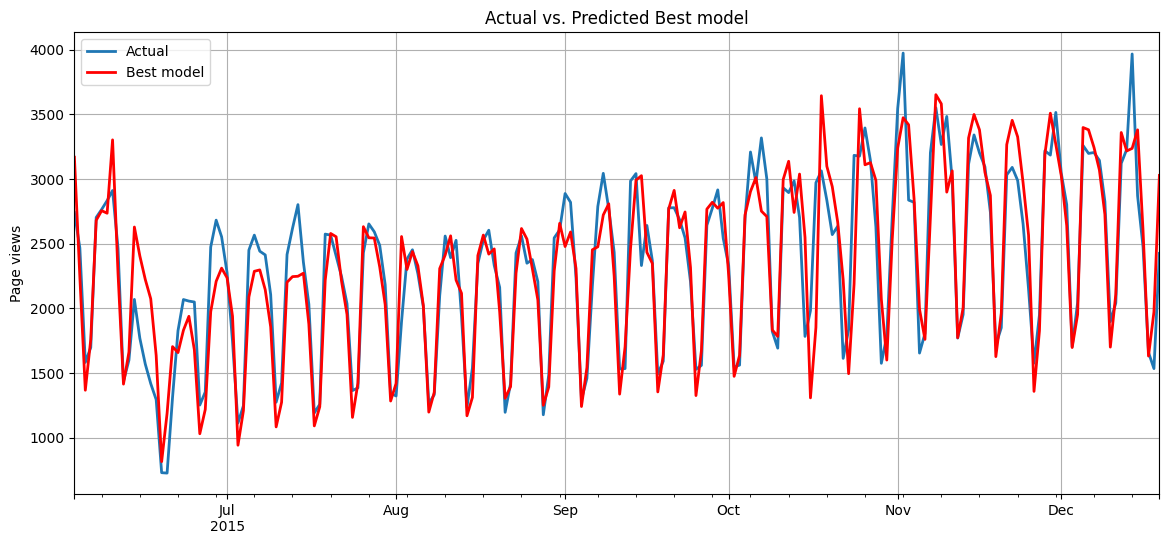

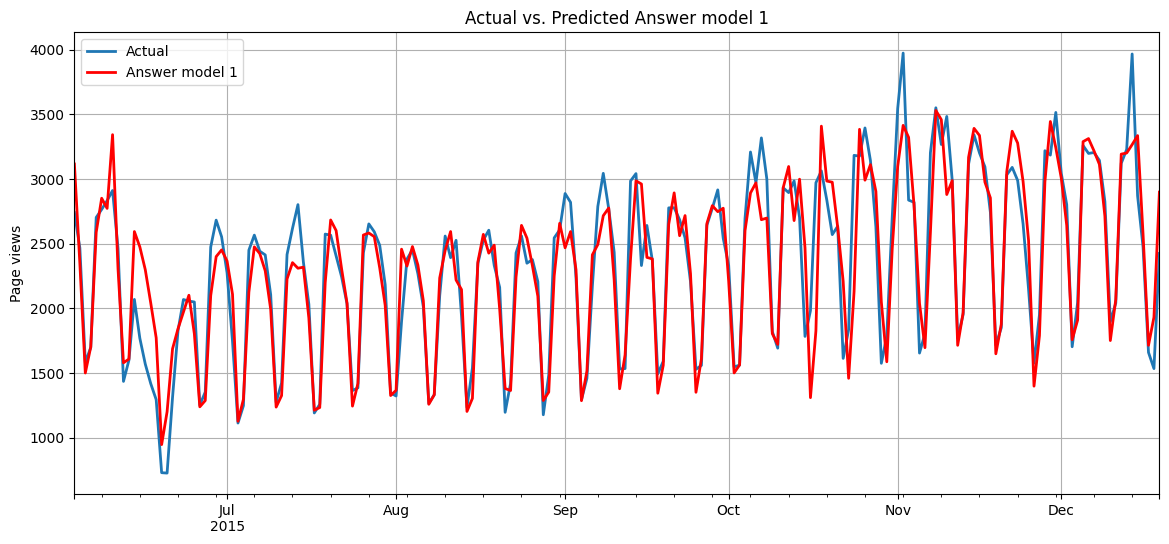

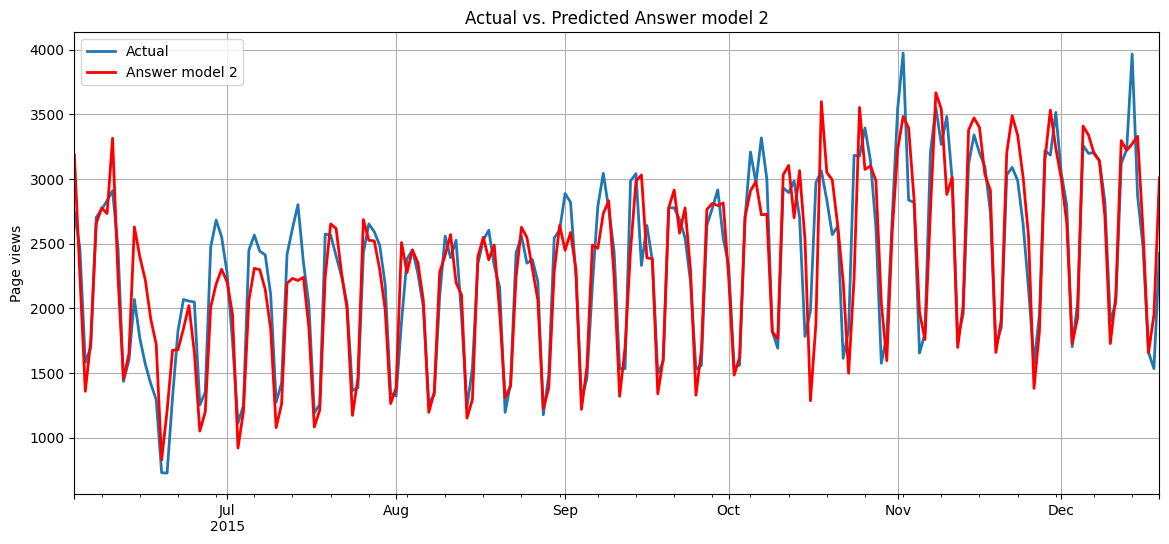

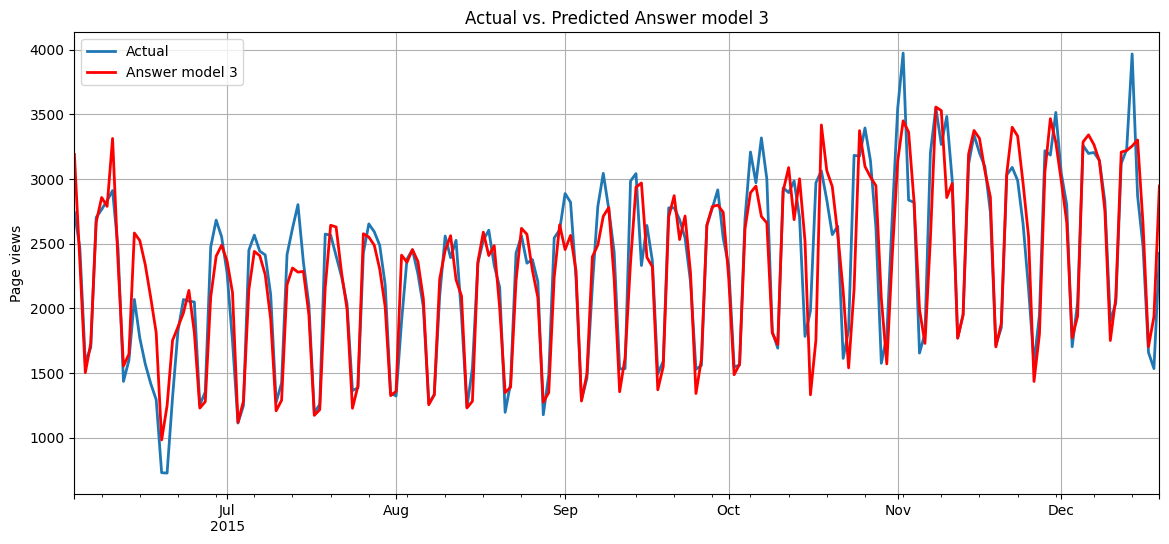

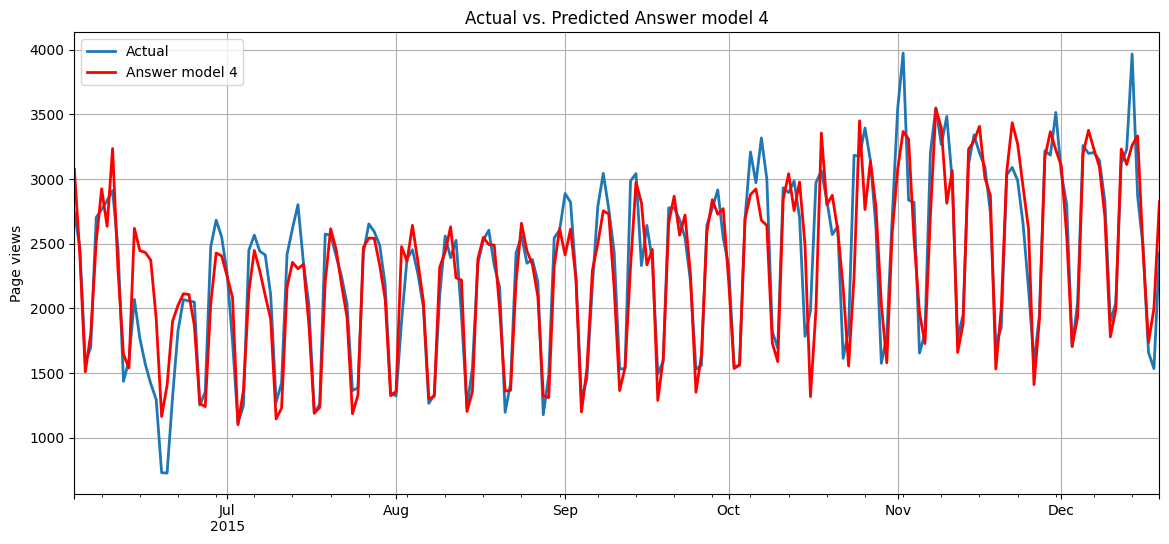

In [41]:
plot_actual_vs_predicted(train_df, boxcox_model, fitted_lambda, 200, predicted_model_title="Best model")
plot_actual_vs_predicted(train_df, model_ans_1[0], fitted_lambda, 200, predicted_model_title="Answer model 1")
plot_actual_vs_predicted(train_df, model_ans_2[0], fitted_lambda, 200, predicted_model_title="Answer model 2")
plot_actual_vs_predicted(train_df, model_ans_3[0], fitted_lambda, 200, predicted_model_title="Answer model 3")
plot_actual_vs_predicted(train_df, model_ans_4[0], fitted_lambda, 200, predicted_model_title="Answer model 4")